# Physics Informed Dynamical Inference (I): Introduction to JAX
Author: Addison Howe

*JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.* (From the [JAX documentation](https://github.com/google/jax).)
 
JAX offers automatic differentiation capabilities, similar to packages such as Pytorch and Tensorflow. 
It also offers just-in-time compilation for user-defined Python functions, meaning that your code will run faster, with less overhead from the Python interpreter.
Again from the JAX Github: "Compilation and automatic differentiation can be composed arbitrarily, so you can express sophisticated algorithms and get maximal performance without leaving Python."

## Installing JAX

Assuming that you've installed conda on your system, you can install JAX in your current conda environment by running `conda install jax` from the command line.
For the purposes of this tutorial, we'll start by making a fresh conda environment. 
In the command line, run
```bash
conda create -n jaxenv python=3.10 numpy=1.26 matplotlib=3.8 jax=0.4 diffrax=0.5 ipykernel
conda activate jaxenv
```
This will create a new environment, called `jaxenv`, that will contain the JAX-related packages we'll be using.
Test that you can import the `jax` and `diffrax` libraries by running 
```bash
python -c "import jax; import diffrax; print('Success!')"
```
Note that this installation should be fine for our purposes, since we'll be running all of our code on a CPU. 
However, if you want to use JAX for your own research, taking advantage of high-performance architectures such as GPUs, you'll want to take a look at the other [installation options](https://github.com/google/jax?tab=readme-ov-file#installation).


## JAX Basics
Now that we've successfully installed JAX, let's dive into some basic functionality.
Feel free to check out the [JAX Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) page for additional information.

JAX comes with its own "version" of numpy, which feels a lot like the standard numpy package.
Pretty much everything we can do in numpy, we can also do in JAX.
One important thing to note is that JAX by default works with single-precision data, i.e. arrays have float32 or int32 datatypes.
For machine learning applications, this is fairly common, but if we want 64-bit data for scientific computing purposes, we can set an environment variable or change a configuration setting, as we do below.
More details about this can be found in the [documentation](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision).

In [1]:
# If you want double precision datatypes, this needs to be done at startup,
# when you first import stuff from jax.
from jax import config
config.update("jax_enable_x64", True)

# JAX's version of numpy
import jax.numpy as jnp

jnp.array([1,2,3])  # create an array. Notice the datatype is int64

Array([1, 2, 3], dtype=int64)

Notice the datatype of the array is `int64`. If you restart your kernel and comment out the `config.update(...)` line, you'll see that without it the array will be `int32` instead.
Let's do some basic operations with arrays.

In [2]:
x = jnp.array([1, 2, 3], dtype=jnp.float64)  # explicitly request float64 data
y = jnp.array([1, 0, 1], dtype=jnp.float64)

print("x                    :", x)
print("y                    :", y)
print("x + y                :", x + y)
print("jnp.linalg.norm(y)   :", jnp.linalg.norm(y))
print("2*x + 3*y            :", 2*x + 3*y)
print("jnp.dot(x,y)         :", jnp.dot(x, y))

x                    : [1. 2. 3.]
y                    : [1. 0. 1.]
x + y                : [2. 2. 4.]
jnp.linalg.norm(y)   : 1.4142135623730951
2*x + 3*y            : [5. 4. 9.]
jnp.dot(x,y)         : 4.0


Some other helpful carryovers from numpy that we'll make use...

In [3]:
print(jnp.linspace(0, 1, 5))
print(jnp.ones([3,2]))

[0.   0.25 0.5  0.75 1.  ]
[[1. 1.]
 [1. 1.]
 [1. 1.]]


## Automatic Differentiation and Vecorization in JAX

Two features that make JAX very powerful for scientific computing include its [automatic differentiation](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#the-autodiff-cookbook) and [vectorization](https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html#automatic-vectorization) capabilities.

### Basic differentiation with `grad`

We can take derivatives of scalar functions easily, using the `jax.grad` function. By default, `jax.grad` takes in a function `f(x, ...)` and returns another function, the derivative of the function `f` with respect to its first argument, `x`.

In [4]:
import matplotlib.pyplot as plt
from jax import grad

In [5]:
f = jnp.sin  # f is the sine function, defined in jax.numpy

fx = grad(jnp.sin)                # fx is the 1st derivative of sine
fxx = grad(grad(jnp.sin))         # fxx is the 2nd derivative of sine
fxxx = grad(grad(grad(jnp.sin)))  # fxxx is the 3rd derivative of sine

# Warning: the inputs to these functions must be floats, not integers.
# If you use int 0 instead of float 0. (with a period) an error will be thrown.

print(f"   f(0) = { f(0.) }")
print(f"  f'(0) = { fx(0.) }")
print(f" f''(0) = { fxx(0.) }")
print(f"f'''(0) = { fxxx(0.) }")


   f(0) = 0.0
  f'(0) = 1.0
 f''(0) = -0.0
f'''(0) = -1.0


We can also use the `grad` function to differentiate functions with respect to positional arguments.
As an example, consider the function 
$$f(x,y) = xy^2$$
with 
$$
\begin{align}
    \frac{\partial}{\partial x}f(x,y) &= y^2 \\
    \frac{\partial}{\partial y}f(x,y) &= 2xy
\end{align}
$$


In [6]:
def f(x, y):
    return x*y*y

fx = grad(f, 0)  # Derivative in the 0th argument (x). Same as grad(f).
fy = grad(f, 1)  # Derivative in the 1st argument (y).

x = 2.
y = 3.

print(f" f = {f(x, y)}")
print(f"fx = {fx(x, y)}")
print(f"fy = {fy(x, y)}")

 f = 18.0
fx = 9.0
fy = 12.0


Often in computing we will deal with functions $f:\mathbb{R}^n\to\mathbb{R}^m$, where $n$ and $m$ can be very large.
In these cases, we'll often define our python functions in terms of inputs that we assume to be vectors, or arrays.
For example, if we think of the function above as mapping a 2-vector to a scalar, $f:\mathbb{R}^2\to\mathbb{R}$, we can rewrite it in python, treating its input `x` as a 2-vector $(x,y)$.
Then, if we take the gradient of $f$ with respect to the first input, it should return the gradient *vector*, $(f_x, f_y)$.

In [7]:
# Now `x` represents the 2-vector (x,y) 
def f(x):
    return x[0] * x[1] * x[1]

x = jnp.array([2., 3.])  # still use the point (x, y) = (2, 3)

g = grad(f)

print(f"        f(x) = {f(x)}")
print(f"(grad(f))(x) = {g(x)}")

        f(x) = 18.0
(grad(f))(x) = [ 9. 12.]


### Vectorizing functions using `vmap`

If you've used numpy before, you probably know that it is convenient for vectorized operations, meaning that if you define a function and use "basic" operations, you can often apply the function over an array of inputs, and it just works. For example,

In [8]:
def f(x, y):
    return x * y * y

x = jnp.array([2., 1., 3.])
y = jnp.array([3., 2., 1.])

print(f(x, y))

[18.  4.  3.]


However, we run into a problem if we try to do something like this with the gradient version of the function. 
The following code will produce an error...

In [9]:
def f(x, y):
    return x * y * y

x = jnp.array([2., 1., 3.])
y = jnp.array([3., 2., 1.])

grad_f = grad(f, 1)  # take the partial derivative with respect to y.

try:
    grad_f(x, y)  # this raises an error!
except TypeError as e:
    print("Encountered an error:", e)

Encountered an error: Gradient only defined for scalar-output functions. Output had shape: (3,).


To get around this, we can use the `jax.vmap` function to vectorize arbitrary functions.
This is a very convenient and flexible feature, that allows us to vectorize over certain axes of certain inputs. 
For example, to achieve what we want above, we can vectorize the gradient function so that the vectorized version will take in two arrays of length $n$ and return an array of length $n$.

In [10]:
from jax import vmap

def f(x, y):
    return x * y * y

x = jnp.array([2., 1., 3.])
y = jnp.array([3., 2., 1.])

grad_f = grad(f, 1)  # take the partial derivative with respect to y, as above.

# Now we vectorize the gradient function.
# The second argument 0 says to vectorize over the 0th axis of each input.
vectorized_grad = vmap(grad_f, 0)

print(vectorized_grad(x, y))

[12.  4.  6.]


#### Exercise 1: 
Consider the function $f:\mathbb{R}^3\to\mathbb{R}$ with
$$f(x,y,z)=xy+z$$
and define the python function `f(x)` where `x` represents the 3-vector $(x,y,z)$.

1. Use `vmap` to vectorize the function, so that the vectorized version takes a 2D-array of shape `(n, 3)` and returns an array of shape `(n,)`.
2. Use `vmap` and `grad` to construct a vectorized version of the gradient function $\nabla f=(f_x, f_y, f_z)$. This function should take as input a 2d-array of shape `(n, 3)` and return a 2d-array of shape `(n, 3)`.


In [11]:
def f(x):  # `x`` is a 3-vector (x,y,z)
    return x[0] * x[1] + x[2]  # f = xy+z

In [12]:
# Exercise 1.1: Vectorize the function f.

vectorized_f = lambda x: "Not Implemented!"  # ignore this line

#!-------------------------  TODO: YOUR CODE HERE  -------------------------!#
# Construct the function `vectorized_f`.

vectorized_f = vmap(f, 0)

#!--------------------------------------------------------------------------!#

# Input: Array of shape (4, 3)
xs = jnp.array([
    [1, 0, 0],
    [0, 1, 3],
    [1, 1, 1],
    [2, 3, 1],
], dtype=jnp.float64)

result = vectorized_f(xs)
print("Got result:\n", result)

Got result:
 [0. 3. 2. 7.]


In [13]:
# Exercise 1.2: Vectorize the gradient of the function f.

vectorized_grad_f = lambda x: "Not Implemented!"  # ignore this line

#!-------------------------  TODO: YOUR CODE HERE  -------------------------!#
# Construct the function `vectorized_grad_f`.

vectorized_grad_f = vmap(grad(f, 0), 0)

#!--------------------------------------------------------------------------!#

# Input: Array of shape (4, 3)
xs = jnp.array([
    [1, 0, 0],
    [0, 1, 3],
    [1, 1, 1],
    [2, 3, 1],
], dtype=jnp.float64)

result = vectorized_grad_f(xs)
print("Got result:\n", result)

Got result:
 [[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 1.]
 [3. 2. 1.]]


#### Exercise 2:

Use `jax.grad` and `jax.vmap` to plot a function $f$ and its derivative $f'$ over an interval $x\in[-1, 1]$.
Compute arrays `ys` and `yprimes`, the value of the function and its derivative, respectively.

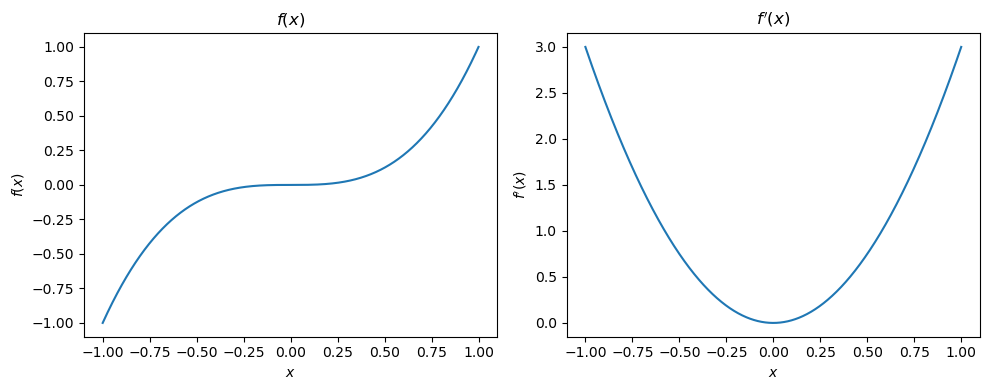

In [14]:
def f(x):
    return x**3  # Feel free to change the function

xs = jnp.linspace(-1, 1, 1000)

ys = 0. * xs        # placeholder for the function
yprimes = 0. * xs   # placeholder for the derivative


#!-------------------------  TODO: YOUR CODE HERE  -------------------------!#
# Compute the arrays `ys` and `yprimes`

ys = f(xs)  # don't need to use vmap in this case
yprimes = vmap(grad(f))(xs)

#!--------------------------------------------------------------------------!#


fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(xs, ys)  # Plot the function
ax1.set_xlabel("$x$")
ax1.set_ylabel("$f(x)$")
ax1.set_title("$f(x)$")

ax2.plot(xs, yprimes)  # Plot the derivative
ax2.set_xlabel("$x$")
ax2.set_ylabel("$f'(x)$")
ax2.set_title("$f'(x)$")

plt.tight_layout()

### More with Vector-Valued Functions: Jacobians

Recall that the Jacobian matrix $J\in\mathbb{R}^{m\times n}$ of a transformation $F:\mathbb{R}^n\to\mathbb{R}^m$ is an $m\times n$ matrix containing the partial derivatives of each component of $F$ with respect to each input. That is,
$$J_{ij} = \frac{\partial F_i}{\partial x_j}.$$

For example, if 
$$F(x,y) = \begin{bmatrix}  xy \\ xy^2 \\ x^2 y \end{bmatrix}, \;\;\; F:\mathbb{R}^2\to\mathbb{R}^3$$
then the Jacobian of $F$ is
$$
J(x,y) = \begin{bmatrix} 
    y   & x \\
    y^2 & 2xy \\
    2xy & x^2
\end{bmatrix}.
$$

JAX offers two functions to compute the Jacobian, `jacfwd` and `jacrev`.
Both functions will compute the Jacobian correctly, but `jacfwd` uses forward-mode automatic differentiation, while `jacrev` uses reverse-mode.
This difference in implementation comes down to whether the Jacobian is computed column by column, or row by row. 
If the Jacobian is "tall," as in the example above with $m > n$, then forward-mode is more efficient.
If the Jacobian is "wide," with more columns than rows, $n\gg m$, then reverse-mode is more efficient.
For more details regarding the specific implementation of these functions, and the mathematics behind them, refer to the [documentation](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev).


In [15]:
from jax import jacfwd, jacrev

def F(x):
    return jnp.array([ 
        x[0] * x[1],            # xy
        x[0] * x[1] * x[1],     # x y^2
        x[0] * x[0] * x[1],     # x^2 y
    ])

x = jnp.array([1., 2.])

J = jacfwd(F)

print(J(x))


[[2. 1.]
 [4. 4.]
 [4. 1.]]


## Random Number Generation in JAX

The computational performance that JAX offers requires that all functions be deterministic. 
One consequence of this is that random number generation feels a little different in JAX than in, for example, numpy and scipy.
To inject "randomness" into a program, we start by making a psuedo-random number generator `key`.
This can be thought of as a seed for any "random" function we want to use.
Each time we want to call such a function, we first "split" the key into two subkeys.
One subkey is retained and becomes our new `key` to use down the road.
The other subkey we pass into the random function.

To demonstrate...

In [16]:
import jax.random as jrandom

key = jrandom.PRNGKey(seed=42)  # create a key, (looks like a pair of integers)
print("Our initial key:", key)

print("Split the key into key and subkey...")
key, subkey = jrandom.split(key)  # split the key into 2 parts: key and subkey
print("   key is now:", key)
print("subkey is now:", subkey)

print("\nGenerate data with subkey...")
x = jrandom.normal(subkey, shape=[1, 3])  # use subkey to generate Gaussian data
print("x:", x)

print("\nGenerate data with the same subkey again...")
y = jrandom.normal(subkey, shape=[1, 3])  # Get the same data!
print("y:", y)

Our initial key: [ 0 42]
Split the key into key and subkey...
   key is now: [2465931498 3679230171]
subkey is now: [255383827 267815257]

Generate data with subkey...
x: [[-0.55338771  0.94428308  0.14538109]]

Generate data with the same subkey again...
y: [[-0.55338771  0.94428308  0.14538109]]


The takeaway is to not reuse `subkey`. Instead, after each use, split `key` to get a new `subkey`.

In [17]:
key = jrandom.PRNGKey(seed=42)  # create a key, which looks like 2 numbers
print("Our initial key:", key)

print("Split the key into key and subkey...")
key, subkey = jrandom.split(key)  # split the key into 2 parts: key and subkey
print("   key is now:", key)
print("subkey is now:", subkey)

print("\nGenerate data with subkey...")
x = jrandom.normal(subkey, shape=[1, 3])  # use subkey to generate Gaussian data
print("x:", x)

print("\nSplit the key into key and subkey again...")
key, subkey = jrandom.split(key)  # split the key into 2 parts: key and subkey
print("   key is now:", key)
print("subkey is now:", subkey)

print("\nGenerate data with the new subkey...")
y = jrandom.normal(subkey, shape=[1, 3]) 
print("y:", y)  # y is different from x

Our initial key: [ 0 42]
Split the key into key and subkey...
   key is now: [2465931498 3679230171]
subkey is now: [255383827 267815257]

Generate data with subkey...
x: [[-0.55338771  0.94428308  0.14538109]]

Split the key into key and subkey again...
   key is now: [3164236999 3984487275]
subkey is now: [3923418436 1366451097]

Generate data with the new subkey...
y: [[-0.32761323 -0.40663464  0.89080702]]


### JIT Compilation: Making code faster

One reason to use JAX is that it allows you to take advantage of the ease and convenience of Python, while offering performance increases that are usually not available due to the overhead of the Python interpreter, which executes python code line by line.

The way JAX does this is through just-in-time (JIT) compilation.
The function `jax.jit` takes in a function and returns a compiled, or "jitted," version.
The first time a jitted function is called, its "instructions" are essentially saved, and future calls to the function are faster (sometimes *much* faster).
For more information , take a look at the [documentation](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions).

In [18]:
from jax import jit

# Example from https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions

# Define a somewhat complicated function
def myfunc(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

key, subkey = jrandom.split(key)
x = jrandom.normal(subkey, (1000000,))  # make a large array


Time the non-compiled function...

In [19]:
%timeit -n 100 myfunc(x)

4.35 ms ± 431 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now apply `jit` to the function, and time the jitted version...

In [20]:
myfunc_jit = jit(myfunc)  # `myfunc_jit` is a function that acts just like `myfunction`

In [21]:
%timeit -n 100 myfunc_jit(x)

1.95 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The difference between the two will likely vary on different computers, but you should see that the jitted version is faster.